In [4]:
# simulate a clustering dynamics process
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import numpy as np
import pandas as pd
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt


if tf.config.list_physical_devices('GPU'):
  print("TensorFlow is using GPU computing")
else:
  print("TensorFlow is not using GPU computing")


d=tf.constant(2, dtype =tf.int32)
n=tf.constant(100, dtype =tf.int32)

n_nodes = tf.constant(100000, dtype =tf.int32)
p=tf.constant(10, dtype =tf.int32)
time_interval = tf.constant(range(1, n+1), dtype =tf.int32)
X_true_I = np.zeros((n, p, d))
X_true_II = np.zeros((n, p, d))
#X_true = np.zeros((n, n_nodes, d))
alpha = tf.constant(3., dtype = tf.float64)
Z = tf.constant(0., dtype = tf.float64)
cl_I = tf.constant(np.floor(np.random.uniform(0, p, n_nodes)), dtype=tf.int32)
cl_II = tf.constant(np.floor(np.random.uniform(0, p, n_nodes)), dtype=tf.int32)

for i in range(p):
  shift = np.random.uniform(0.2, 0.8, 1)
  for j in range(d):
    X_true_I[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-shift)) -0.5)*np.random.uniform(1, 2, 1) + np.random.uniform(-1.5, 1.5, 1)
    plt.plot(X_true_I[ :, i, j])

plt.figure()
for t in range(100):
  plt.scatter(X_true_I[ t, :, 0], X_true_I[ t, :, 1])

plt.figure()
for i in range(p):
  shift = np.random.uniform(0.2, 0.8, 1)
  for j in range(d):
    X_true_II[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-shift)) -0.5)*np.random.uniform(0.1, 0.3, 1) + np.random.uniform(-0.05, 0.05, 1)
    plt.plot(X_true_II[ :, i, j])


X_true_I = tf.constant(X_true_I, dtype=tf.float64)
X_true_I = tf.reshape(X_true_I, (-1, 2))
X_true_II = tf.constant(X_true_II, dtype=tf.float64)
X_true_II = tf.reshape(X_true_II, (-1, 2))



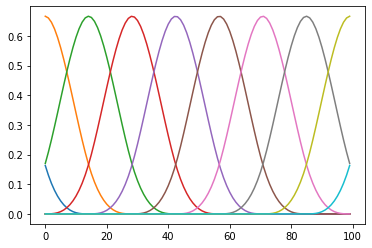

In [5]:
n_basis = 10

basis = tf.constant(np.load("basis.npy"), dtype=tf.float64)
penalty_mat = tf.constant(np.load("penalty_pspline.npy"), dtype=tf.float64)
plt.plot(basis)


In [17]:


#choose the type of penaly for the gaussian process
def get_penalty_smooth_variational(mu, log_sigma2):
  mu2 = tf.math.exp(log_sigma2) + tf.square(mu)
  return tf.reduce_sum(mu2[ :, 0:(n_basis-1)] + mu2[ :, 1:(n_basis)]  - 2*mu[ :, 0:(n_basis-1)]*mu[ :, 1:(n_basis)] )

# def get_penalty_smooth_variational(mu, log_sigma2):
#   mu2 = tf.math.exp(log_sigma2) + tf.square(mu)
#   return tf.reduce_sum(mu2[ :, 0:(n_basis-2)] + 4*mu2[ :, 1:(n_basis-1)] + mu2[ :, 2:(n_basis)] - 4*mu[ :, 0:(n_basis-2)]*mu[ :, 1:(n_basis-1)] + 2*mu[ :, 0:(n_basis-2)]*mu[ :, 2:(n_basis)] - 4*mu[ :, 1:(n_basis-1)]*mu[ :, 2:(n_basis)])

def get_penalty_linkage_variational_v2(mu, log_sigma2, cluster_mean):
  mu2 = tf.math.exp(log_sigma2) + tf.square(mu)
  square_diff = tf.reduce_sum(mu2 + tf.square(cluster_mean)  - 2*mu*cluster_mean)
  return square_diff

 

# def get_penalty_linkage_variational(mu, log_sigma2, mu_centroid, log_sigma2_centroid):
#   mu2 = tf.math.exp(log_sigma2) + tf.square(mu)
#   mu2c = tf.math.exp(log_sigma2_centroid) + tf.square(mu_centroid)
#   square_diff = tf.reduce_sum(mu2 + mu2c  - 2*mu*mu_centroid)
#   return square_diff

# def get_penalty_distance_variational(index_centroid, mu_centroid, log_sigma2_centroid):
#   mu2c1 = tf.gather(tf.math.exp(log_sigma2_centroid) + tf.square(mu_centroid), tf.gather(index_centroid, 1, axis=1)) 
#   mu2c2 = tf.gather(tf.math.exp(log_sigma2_centroid) + tf.square(mu_centroid), tf.gather(index_centroid, 2, axis=1)) 
#   mu1 = tf.gather( mu_centroid, tf.gather(index_centroid, 1, axis=1))
#   mu2 = tf.gather( mu_centroid, tf.gather(index_centroid, 2, axis=1))
#   square_diff = tf.reduce_sum(mu2c1 + mu2c2  - 2 * mu1 * mu2, axis=1)
#   return square_diff

# def get_kernel(index_batch, weights_fixed, mu_kernel, log_sigma2_kernel):
#   mu1 = tf.gather(weights_fixed, tf.gather(index_batch, 1, axis=1))
#   mu2 = tf.gather(weights_fixed, tf.gather(index_batch, 2, axis=1))
#   distance_fixed = tf.math.sqrt(tf.reduce_sum(tf.square( mu1 - mu2 ), axis=1))
#   # do not propagate gradient for this constant
#   threshold = tf.stop_gradient(mu_kernel + 1.96 * tf.math.exp(0.5*log_sigma2_kernel))
#   wh = tf.squeeze(tf.where(tf.math.greater(threshold, tf.math.log(distance_fixed) )))
#   return wh

# def get_kernel_variational(index_centroid, weights_fixed, mu_kernel, log_sigma2_kernel):
#   mu1 = tf.gather(weights_fixed, tf.gather(index_centroid, 1, axis=1))
#   mu2 = tf.gather(weights_fixed, tf.gather(index_centroid, 2, axis=1))
#   distance_fixed = tf.math.sqrt(tf.reduce_sum(tf.square( mu1 - mu2 ), axis=1))
#   dist = tfd.Normal(loc= 0., scale=1.)
#   w = 1-dist.cdf((tf.math.log(distance_fixed)-mu_kernel)/tf.math.exp(0.5*log_sigma2_kernel))
#   return w


# def get_penalty_linkage(index_batch, weights, centroid_weights):
#   gaussian_linkage = tf.reduce_sum(tf.square(tf.subtract(tf.gather(weights, tf.gather(index_batch, 1, axis=1)), tf.gather(centroid_weights, tf.gather(index_batch, 1, axis=1)))), axis=1)
#   return tf.add(gaussian_linkage, tf.reduce_sum(tf.square(tf.subtract(tf.gather(weights, tf.gather(index_batch, 2, axis=1)), tf.gather(centroid_weights, tf.gather(index_batch, 2, axis=1)))), axis=1))

# # non variational penalty
# def get_penalty_smooth_OLD(weights, penalty_mat):
#   return tf.einsum('ij,ij->', tf.matmul(weights, penalty_mat), weights)


# def get_penalty_l2(weights) :
#   return tf.reduce_mean(tf.square(weights))


# def get_penalty_smooth(mu, log_sigma2):
#   mu2 = tf.math.exp(log_sigma2) + tf.square(mu)
#   return tf.reduce_sum(mu2[ :, 0:(n_basis-1)] + mu2[ :, 1:(n_basis)]  - 2*mu[ :, 0:(n_basis-1)]*mu[ :, 1:(n_basis)] )

# def get_penalty_sphere(X_fit_1, X_fit_2):
#   a = tf.reduce_mean(tf.square(tf.reduce_sum(tf.square(X_fit_1) - 1/d, axis=1)))
#   return tf.add(a, tf.reduce_mean(tf.square(tf.reduce_sum(tf.square(X_fit_2) - 1/d, axis=1))) )/2

# def get_kernel_w(index_batch, weights_fixed, gamma_kernel_sd):
#   precision = 1/(2*tf.cast(d*n_basis, dtype = tf.float64)*tf.square(gamma_kernel_sd))
#   w = tf.math.exp( tf.scalar_mul(precision, tf.math.negative(tf.reduce_sum(tf.square(tf.math.subtract( tf.gather(weights_fixed, tf.gather(index_batch, 1, axis=1), axis=0), tf.gather(weights_fixed, tf.gather(index_batch, 2, axis=1), axis=0) )), axis=1))  ))
#   #wh = tf.squeeze(tf.where(w > threshold))
#   return w #tf.gather(w, wh), wh


# def get_penalty_distance(index_batch, centroid_weights):
#   return tf.reduce_sum( tf.square( tf.math.subtract( tf.gather(centroid_weights, tf.gather(index_batch, 1, axis=1), axis=0), tf.gather(centroid_weights, tf.gather(index_batch, 2, axis=1), axis=0) )), axis=1)


def get_kernel_w_v3(index_batch, weights_fixed, gamma_kernel_sd):
  w = tf.math.sqrt(tf.reduce_sum(tf.square( tf.gather(weights_fixed, tf.gather(index_batch, 1, axis=1), axis=0) - tf.gather(weights_fixed, tf.gather(index_batch, 2, axis=1), axis=0) ), axis=1))
  # w = tf.cast(tf.math.greater(gamma_kernel_sd, w), tf.float64)
  wh = tf.squeeze(tf.where(tf.math.greater(gamma_kernel_sd, w)))
  return wh

# def get_penalty_linkage_v3(weights, centroid_weights):
#   return tf.reduce_sum(tf.square(weights - centroid_weights))

# def get_penalty_distance_v3(index_batch, centroid_weights):
#   return tf.math.sqrt(tf.reduce_sum( tf.square( tf.gather(centroid_weights, tf.gather(index_batch, 1, axis=1), axis=0) - tf.gather(centroid_weights, tf.gather(index_batch, 2, axis=1), axis=0) ), axis=1))


class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    #trainable variables
    self.intercept = tf.Variable(0., trainable=True, dtype=tf.float64)
    self.mu_smooth = tf.Variable(0., trainable=True, dtype=tf.float64)
    self.mu_linkage = tf.Variable(0., trainable=True, dtype=tf.float64)
    self.mu_kernel = tf.Variable(0., trainable=False)
    #self.mu_dist = tf.Variable(0., trainable=True)
    #self.mu_gamma = tf.Variable(tf.random.uniform(shape = [3] , minval= -0.1, maxval= -0.1, dtype=tf.float64))
    self.log_sigma2_smooth = tf.Variable(-5., dtype=tf.float64)
    self.log_sigma2_linkage = tf.Variable(-5., dtype=tf.float64)
    self.log_sigma2_kernel = tf.Variable(-5., dtype=tf.float64)
    #self.log_sigma2_dist = tf.Variable(-5., dtype=tf.float64)
    # self.mu = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float64))
    self.mu = tf.Variable(tf.fill(dims = [n_nodes, n_basis * d], value= tf.cast(0., dtype=tf.float64)))
    self.log_sigma2 = tf.Variable(tf.fill(dims = [n_nodes, n_basis * d], value= tf.cast(-8., dtype=tf.float64)))
    # self.mu_centroid = tf.Variable(tf.fill(dims = [n_nodes, n_basis * d], value= 0.))
    # self.log_sigma2_centroid = tf.Variable(tf.fill(dims = [n_nodes, n_basis * d], value= -8.))
    #self.weights = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float64))
    #self.centroid_weights = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float64))

    #non trainable variables
    self.Phi = tf.Variable(tf.constant(0, dtype=tf.float64), trainable=False)
    self.mu_prior = tf.constant(0, dtype=tf.float64)
    self.sigma2_prior = tf.constant(1000, dtype=tf.float64)
    # self.fixed_weights = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float64), trainable=False)
    self.cluster_mean = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float64), trainable=False)
    self.basis = tf.constant(basis)
    self.penalty_mat = tf.constant(penalty_mat)
    #self.index_saved_centroid_neighbours = tf.Variable(-tf.ones((batch_size*2,3),  dtype=tf.int32), trainable=False)

  def __call__(self, index_batch, make_clustering, make_spherical, aggregate_centroids, gamma_kernel_sd, gamma_convex_clust):
    gamma_smooth = tf.math.exp( self.mu_smooth + tf.math.exp(self.log_sigma2_smooth)/2 )
    weights = self.mu + tf.math.exp(self.log_sigma2/2) * tf.random.normal(shape = (n_nodes, n_basis * d), dtype=tf.float64)
    self.mu_kernel = - tf.math.exp(self.log_sigma2_kernel/2) * self.Phi
    negKL =   tf.reduce_sum(1 + self.log_sigma2 - tf.math.log(self.sigma2_prior) - (1/self.sigma2_prior) * (tf.math.exp(self.log_sigma2) + tf.square(self.mu - self.mu_prior) )  )/2
    negKL += tf.reduce_sum(1 + self.log_sigma2_smooth - tf.math.log(self.sigma2_prior) - (1/self.sigma2_prior) * (tf.math.exp(self.log_sigma2_smooth) + tf.square(self.mu_smooth - self.mu_prior ) )  )/2
    negKL += tf.reduce_sum(1 + self.log_sigma2_linkage - tf.math.log(self.sigma2_prior) - (1/self.sigma2_prior) * (tf.math.exp(self.log_sigma2_linkage) + tf.square(self.mu_linkage - self.mu_prior ) )  )/2
    negKL += tf.reduce_sum(1 + self.log_sigma2_kernel - tf.math.log(self.sigma2_prior) - (1/self.sigma2_prior) * (tf.math.exp(self.log_sigma2_kernel) + tf.square(self.mu_kernel - self.mu_prior ) )  )/2
    #negKL += tf.reduce_sum(1 + self.log_sigma2_dist - tf.math.log(self.sigma2_prior) - (1/self.sigma2_prior) * (tf.math.exp(self.log_sigma2_dist) + tf.square(self.mu_dist - self.mu_prior ) )  )/2
    time = tf.reshape(tf.gather(self.basis, tf.gather(index_batch, 0, axis=1)), (batch_size, 1, n_basis))
    X_fit_1 = tf.squeeze(tf.matmul(time, tf.reshape(tf.gather(tf.scalar_mul(1, weights), tf.gather(index_batch, 1, axis=1), axis=0), (batch_size, d, n_basis)), transpose_b=True))
    X_fit_2 = tf.squeeze(tf.matmul(time, tf.reshape(tf.gather(tf.scalar_mul(1, weights), tf.gather(index_batch, 2, axis=1), axis=0), (batch_size, d, n_basis)), transpose_b=True))
    #similarity = tf.einsum('ij,ij->i', *get_latent_variables(index_batch, tf.scalar_mul(1, self.weights), self.basis))
    similarity = tf.einsum('ij,ij->i', X_fit_1, X_fit_2)
    # non variational penalty
    #smooth_penalty = get_penalty_smooth_OLD(tf.reshape(self.weights, (-1, n_basis)), self.penalty_mat) 
    smooth_penalty = get_penalty_smooth_variational(tf.reshape(self.mu, (-1, n_basis)), tf.reshape(self.log_sigma2, (-1, n_basis)))
    #l2_penalty = 0. #get_penalty_l2(self.weights)
    sphere_penalty = l2_penalty = cluster_penalty = distance_penalty = num_assign = 0
    # if(make_spherical):
    #   # sphere_penalty = get_penalty_sphere(*get_latent_variables(index_batch, tf.scalar_mul(1, self.weights), self.basis))
    #   sphere_penalty = get_penalty_sphere(X_fit_1, X_fit_2)
    if(make_clustering):
      gamma_linkage = tf.math.exp(self.mu_linkage + tf.math.exp(self.log_sigma2_linkage)/2 )
      linkage_penalty =  get_penalty_linkage_variational_v2(self.mu, self.log_sigma2, self.cluster_mean)
      cluster_penalty = gamma_linkage * linkage_penalty
      # kernel select the entries
      # wh = get_kernel(index_batch, self.fixed_weights, self.mu_kernel, self.log_sigma2_kernel)
      # self.index_saved_centroid_neighbours.assign(tf.concat((tf.reshape(tf.gather(index_batch, wh), [-1,3]), self.index_saved_centroid_neighbours), axis=0)[0:(2*batch_size), :])
      # index_centroid = tf.boolean_mask(self.index_saved_centroid_neighbours, self.index_saved_centroid_neighbours[:, 0]!=-1)
      # nrow = tf.shape(index_centroid)[0]
      # if(nrow > batch_size):
      #   sampled = tf.random.uniform(shape = [batch_size], maxval = nrow, dtype = tf.int32) 
      #   index_centroid = tf.gather(index_centroid , sampled)
      # linkage_penalty =  get_penalty_linkage_variational(self.mu, self.log_sigma2, self.mu_centroid, self.log_sigma2_centroid) 
      # distance_penalty = get_penalty_distance_variational(index_centroid, 1*self.mu_centroid, 1*self.log_sigma2_centroid)
      # w = get_kernel_variational(index_centroid, self.fixed_weights, self.mu_kernel, self.log_sigma2_kernel)
      # gamma_linkage = tf.math.exp(self.mu_linkage + 0.5*tf.math.exp(self.log_sigma2_linkage) )
      # gamma_dist = tf.math.exp(self.mu_dist + 0.5*tf.math.exp(self.log_sigma2_dist) )
      # cluster_penalty = gamma_linkage * linkage_penalty + tf.cast(batch_size, dtype = tf.float64) *  gamma_dist * tf.reduce_mean(w * distance_penalty)      
      # num_assign = tf.size(wh)
    return tf.math.add(self.intercept, similarity), (smooth_penalty, cluster_penalty, sphere_penalty, num_assign, l2_penalty, negKL, gamma_smooth) 

####################### dense network only ########################

def log_poisson(y_target, linear_predictor):
  return  tf.math.add(tf.math.negative(tf.math.exp(linear_predictor)), tf.math.multiply(linear_predictor, y_target))
 
def loss(y_target, y_predicted):
  y_predicted, penalties = y_predicted
  return  tf.math.negative(tf.reduce_sum(log_poisson(y_target, y_predicted))), penalties 

def generator():
  t = tf.random.uniform(shape = [batch_size], maxval = n, dtype = tf.int32)
  i = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  j = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  while tf.reduce_any(i==j):
    j = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  #res_index = tf.stack((t, i, j), axis=1)
  #res_index = tf.stack(( tf.math.add(tf.math.scalar_mul(n_nodes, t), i), tf.math.add(tf.math.scalar_mul(n_nodes, t), j)), axis=1)
  X_true_1 = tf.gather(X_true_I, tf.math.scalar_mul(p, t) + tf.gather(cl_I, i)) + tf.gather(X_true_II, tf.math.scalar_mul(p, t) + tf.gather(cl_II, i))
  X_true_2 = tf.gather(X_true_I, tf.math.scalar_mul(p, t) + tf.gather(cl_I, j)) + tf.gather(X_true_II, tf.math.scalar_mul(p, t) + tf.gather(cl_II, j))
  #sample = tfd.Poisson(log_rate = tf.math.add(alpha, tf.einsum('ij,ij->i', tf.gather(X_true, tf.gather(res_index, 0, axis=1), axis=0 ), tf.gather(X_true, tf.gather(res_index, 1, axis=1), axis=0 ))) ).sample(1)
  #sample = tfd.Poisson(log_rate = tf.math.add(alpha, tf.einsum('ij,ij->i', X_true_1, X_true_2)) ).sample(1)
  yield tf.stack((t, i, j), axis=1), tf.reshape(tfd.Poisson(log_rate = tf.math.add(alpha, tf.einsum('ij,ij->i', X_true_1, X_true_2)) ).sample(1), -1)


@tf.function
def train(model, index_batch, y_batch, optimizer, hyper_params, make_clustering, make_spherical, aggregate_centroids):
  gamma_smooth_OLD, gamma_linkage_OLD, gamma_convex_clust, gamma_kernel_sd_OLD, gamma_sphere, gamma_l2 = hyper_params
  with tf.GradientTape() as tape:
    current_loss, penalties = loss(y_batch, model(index_batch, make_clustering, make_spherical, aggregate_centroids, gamma_kernel_sd_OLD, gamma_convex_clust))
    smooth_penalty, cluster_penalty, sphere_penalty, num_assign, l2_penalty, negKL, gamma_smooth = penalties
    penalized_loss = -negKL/tf.cast((n_nodes-1)*n, dtype = tf.float64) + current_loss + gamma_smooth*smooth_penalty/tf.cast(n_nodes, dtype = tf.float64) + cluster_penalty
  dw = tape.gradient(penalized_loss, model.trainable_variables)
  optimizer.apply_gradients(zip( dw, model.trainable_variables))
  return current_loss, cluster_penalty, penalized_loss #, num_assign, negKL

#########################################################################
batch_size = tf.cast(2*n_nodes, dtype = tf.int32)

train_dataset = tf.data.Dataset.from_generator(
     generator,
     output_signature=(
         tf.TensorSpec(shape=(None, 3), dtype=tf.int32),
         tf.TensorSpec(shape=(None, ), dtype=tf.float64)))

train_dataset = train_dataset.repeat().take(1000)



#negKL/tf.cast(n*n_nodes*(n_nodes-1), dtype = tf.float64)
#0.5 * tf.reduce_sum(1 + model.log_sigma2_variational - tf.math.log(model.sigma2_prior) - (1/model.sigma2_prior) * (tf.math.exp(model.log_sigma2_variational) + tf.square(model.mu_variational - model.mu_prior) )  )/tf.cast(n*n_nodes*(n_nodes-1), dtype = tf.float64)



# Inf_const = tf.constant(np.Inf, dtype=tf.float64)
# loss_batch = tf.Variable(np.Inf, dtype = tf.float64, trainable=False)
# convex_clustering_loss_batch = tf.Variable(np.Inf, dtype = tf.float64, trainable=False)
def training_loop(model, optimizer, hyper_params, make_clustering, make_spherical, aggregate_centroids, print_freq):
  loss_save =  []
  penalized_loss_save =  []
  for step_batch, (index_batch, y_batch) in enumerate(train_dataset):
    current_loss, convex_clustering_loss, penalized_loss = train(model, index_batch, y_batch, optimizer, hyper_params, make_clustering, make_spherical, aggregate_centroids)
    loss_save.append(current_loss)
    penalized_loss_save.append(penalized_loss)
    if(((step_batch % print_freq) == 0) & (step_batch!=0)):
      tf.print("num batches=", step_batch, "  min out_of_fold loss=", tf.reduce_min([loss_save]), "min negELBO=", tf.reduce_min([penalized_loss_save]))
  return loss_save, penalized_loss_save








model = MyModel()
# model = MyModel_OLD()
#optimizer = tf.optimizers.Adam(beta_1=0.95)
optimizer = tf.optimizers.Adam(learning_rate=0.01)
gamma_smooth = tf.constant(0.00001, dtype= tf.float64) # 0.00001 for dense network, 0.0001 for sparse
gamma_linkage = tf.constant(0.000001, dtype= tf.float64)
gamma_convex_clust = tf.constant(1, dtype= tf.float64) 
gamma_kernel_sd = tf.constant(0.5, dtype= tf.float64) 
gamma_sphere = tf.constant(100, dtype= tf.float64)
gamma_l2 = tf.constant(0, dtype= tf.float64)

make_clustering = False
make_spherical = False
aggregate_centroids = False
#tf.config.run_functions_eagerly(False)

model.mu_smooth.assign(tf.math.log(tf.cast(1000., tf.float64)))
# model.log_mu_gamma_linkage_variational.assign(tf.math.log(0.000001))
# model.log_mu_gamma_kernel_variational.assign(tf.math.log(0.5))
# tf.print(tf.exp(model.log_mu_gamma_smooth_variational + tf.exp(model.log_sigma2_gamma_variational)[0]/2))


ls, pls = training_loop(model, optimizer, (gamma_smooth, gamma_linkage, gamma_convex_clust, gamma_kernel_sd, gamma_sphere, gamma_l2), make_clustering, make_spherical, aggregate_centroids, 10)
tf.print(model.mu_smooth)
tf.print(tf.exp(model.mu_smooth + tf.exp(model.log_sigma2_smooth)/2))
tf.print(tf.reduce_min(model.log_sigma2))
tf.print(tf.reduce_max(model.log_sigma2))
tf.print(tf.reduce_mean(model.log_sigma2))


plt.plot(ls)
plt.figure()
plt.plot(pls)



#pls_unconstrained = pls
# so you get better results increasing the smoothness because you simulate from straight trajectories and the model cannot recover the microstructure
# hence you shrink, get the straight path, then you dont move because is a stable position, as in cannot detect any change in the microstructure
# try to increase the long term memory in Adam

# tf.cast((n_nodes-1)*n/2, dtype = tf.float64)
# n_nodes*(n_nodes-1)*n/2

# n_nodes64 = tf.cast(n_nodes, dtype = tf.int64)
# n64 = tf.cast(n, dtype = tf.int64)
# n_nodes64*(n_nodes64-1)*n64/2


# get_penalty_smooth_OLD(tf.reshape(model.mu_variational, (-1, n_basis)), penalty_mat)
# mu = tf.reshape(model.mu_variational, (-1, n_basis))
# tf.reduce_sum(tf.square( mu[ :, 0:(n_basis-2)] -2 *mu[ :, 1:(n_basis-1)] + mu[ :, 2:(n_basis)] )) *0.0625


# d={}



# cluster_allocation = tf.Variable(tf.range(batch_size, dtype=tf.int32), trainable=False)
# clust =[[1,2], [2,3], [4,5], [5,6], [7, 8]]
# G= nx.Graph()
# G.add_edges_from(clust)
# components = nx.connected_components(G)
# c = list(components)
# for i, c in enumerate(components):
#   print(c)

# d[(1,2)]
# d[2]


<tf.Tensor: shape=(), dtype=int32, numpy=100000>

In [51]:
import networkx as nx

G= nx.Graph()
cluster_allocation = tf.Variable(tf.range(n_nodes, dtype=tf.int32), trainable=False)
fixed_weights = model.mu

train_dataset = train_dataset.repeat().take(10)
for step_batch, (index_batch, y_batch) in enumerate(train_dataset):
  wh = get_kernel_w_v3(index_batch, fixed_weights, 1.0 * 10.)
  index_centroid = tf.reshape(tf.gather(index_batch[:, 1:3], wh), [-1,2])
  #tf.print(tf.shape(index_centroid)[0])
  clust = tf.gather(cluster_allocation, index_centroid)
  index_centroid = tf.boolean_mask(index_centroid, clust[:, 0] != clust[:, 1])
  if(tf.shape(index_centroid)[0]>0):
    G.add_edges_from(index_centroid.numpy())
  tf.print(tf.shape(index_centroid)[0])
      
        
        
components = nx.connected_components(G)
# a=list(components)[0]
for i, c in enumerate(components):
  cm = tf.reduce_mean(tf.gather(model.mu, list(c)), axis=0)
  cluster_allocation.assign(tf.tensor_scatter_nd_update(cluster_allocation, tf.reshape(list(c), [-1, 1]), tf.fill([len(c)], i)))
  model.cluster_mean.assign(tf.tensor_scatter_nd_update(model.cluster_mean, tf.reshape(list(c), [-1, 1]), tf.repeat(tf.reshape(cm, [1,-1]), repeats=[len(c)], axis=0)))
  print(i)

# get mu and sigma for kernel
model.Phi.assign(tf.cast(tfd.Normal(loc= 0., scale=1.).quantile(0.99), tf.float64) )
tf.reduce_mean(cluster_allocation)

#clustering classification correctness
#tf.math.confusion_matrix(cluster_allocation, cl_I)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [56]:
#re-run  tf.function


# mu_save = model.mu
# sigma2_save = model.log_sigma2

# #model.trainable_variables
# #tf.reduce_all(model.fixed_weights == weights_save)

# #tf.reduce_all(model.centroid_weights == model.weights)
# model.mu.assign(mu_save)
# model.log_sigma2.assign(sigma2_save)
# model.fixed_weights.assign(model.mu)
# model.mu_centroid.assign(model.mu)
# model.log_sigma2_centroid.assign(model.log_sigma2)
train_dataset = train_dataset.repeat().take(1000)
make_clustering = True
make_spherical = False
aggregate_centroids = False
#tf.config.run_functions_eagerly(False)
#model.mu_kernel.assign(tf.math.log(1.))
model.mu_linkage.assign(tf.math.log(tf.cast(1., tf.float64)))
#model.mu_dist.assign(tf.math.log(1.))
model.log_sigma2_kernel.assign(-5.)
model.log_sigma2_linkage.assign(tf.cast(-5., tf.float64))
#model.log_sigma2_dist.assign(-5.)

ls, pls = training_loop(model, optimizer, (gamma_smooth, gamma_linkage, gamma_convex_clust, gamma_kernel_sd, gamma_sphere, gamma_l2), make_clustering, make_spherical, aggregate_centroids, 10)
#tf.print(tf.math.exp(model.mu_kernel + 1.96 * tf.math.exp(0.5*model.log_sigma2_kernel)) )
#tf.print(model.log_sigma2_kernel) 
tf.print(tf.exp(model.mu_linkage + tf.exp(model.log_sigma2_linkage)/2))
#tf.print(tf.exp(model.mu_dist + tf.exp(model.log_sigma2_dist)/2))
plt.boxplot(ls)
plt.boxplot(pls)
# pls_r05 = pls
# ls_r05 = ls
# pls_r1 = pls
# ls_r1 = ls
# pls_r10 = pls
# ls_r10 = ls
tf.print(tf.reduce_mean(pls_r10), tf.reduce_mean(pls_r1),tf.reduce_mean(pls_r05))
tf.print(tf.reduce_mean(pls_r10), tf.reduce_mean(ls_r1),tf.reduce_mean(ls_r05))

-703223473.38015044 -704539562.86745751 -703925845.62804079
-703223473.38015044 -704539715.16065407 -703926429.81744683


In [ ]:
model.log_mu_gamma_smooth_variational

# plot results
#X_fit = tf.reshape( tf.matmul(basis, tf.reshape(tf.split(model.weights, 2, axis=1)[0], (n_nodes*d, n_basis)), transpose_b=True), (n, n_nodes, d))
X_fit = tf.reshape( tf.matmul(basis, tf.reshape(model.mu, (n_nodes*d, n_basis)), transpose_b=True), (n, n_nodes, d))
X_true_I = tf.reshape(X_true_I, (n, p, d))
X_true_II = tf.reshape(X_true_II, (n, p, d))

n_plots = 10
i_vec= tf.random.uniform(shape = [n_plots**2], maxval = n_nodes, dtype = tf.int32)
ind = 0
fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
for i in range(n_plots):
  for j in range(n_plots):
    X_true_1 = X_true_I[:, cl_I[i_vec[ind]], :] + X_true_II[:, cl_II[i_vec[ind]], :]
    axs[ i, j].plot( tf.reduce_sum(X_true_1 * X_true_1, axis=1))
    axs[ i, j].plot( tf.reduce_sum(X_fit[:, i_vec[ind], :] * X_fit[:, i_vec[ind], :], axis=1))
    ind += 1 

X_true_I = tf.reshape(X_true_I, (-1, 2))
X_true_II = tf.reshape(X_true_II, (-1, 2))


plt.plot(X_fit[:, i_vec[2], :])
plt.plot(tf.reduce_sum(X_fit[:, i_vec[2], :]*X_fit[:, i_vec[2], :], axis=1))
X_true_1 = X_true_I[:, cl_I[i_vec[2]], :] + X_true_II[:, cl_II[i_vec[2]], :]
plt.figure()
plt.plot(X_true_1)
plt.plot( tf.reduce_sum(X_true_1 * X_true_1, axis=1))

X_fit = tf.reshape( tf.matmul(basis, tf.reshape(model.mu, (n_nodes*d, n_basis)), transpose_b=True), (n, n_nodes, d))
X_true_I = tf.reshape(X_true_I, (n, p, d))
X_true_II = tf.reshape(X_true_II, (n, p, d))

n_plots = p
n_nodes_sample = 20
for i in range(p):
  plt.figure()
  X_true_1 = X_true_I[:, i, :] 
  plt.plot( tf.reduce_sum(X_true_1 * X_true_1, axis=1), linewidth=5)
  a = tf.reshape(tf.where(cl_I==i), -1)
  a = tf.gather(a, tf.random.uniform(shape = [n_nodes_sample], maxval = len(a), dtype = tf.int32))
  for j in range(n_nodes_sample):
    plt.plot(tf.reduce_sum( X_fit[:, a[j], :] * X_fit[:, a[j], :], axis=1))

X_true_I = tf.reshape(X_true_I, (-1, 2))
X_true_II = tf.reshape(X_true_II, (-1, 2))


X_fit = tf.reshape( tf.matmul(basis, tf.reshape(model.cluster_mean, (n_nodes*d, n_basis)), transpose_b=True), (n, n_nodes, d))
X_true_I = tf.reshape(X_true_I, (n, p, d))
X_true_II = tf.reshape(X_true_II, (n, p, d))

n_plots = p
n_nodes_sample = 20
for i in range(p):
  plt.figure()
  X_true_1 = X_true_I[:, i, :] 
  plt.plot( tf.reduce_sum(X_true_1 * X_true_1, axis=1), linewidth=5)
  a = tf.reshape(tf.where(cl_I==i), -1)
  a = tf.gather(a, tf.random.uniform(shape = [n_nodes_sample], maxval = len(a), dtype = tf.int32))
  for j in range(n_nodes_sample):
    plt.plot(tf.reduce_sum( X_fit[:, a[j], :] * X_fit[:, a[j], :], axis=1))

X_true_I = tf.reshape(X_true_I, (-1, 2))
X_true_II = tf.reshape(X_true_II, (-1, 2))


X_fit = tf.reshape( tf.matmul(basis, tf.reshape(model.weights, (n_nodes*d, n_basis)), transpose_b=True), (n, n_nodes, d))
n_plots = 10
i_vec= tf.random.uniform(shape = [n_plots**2], maxval = n_nodes, dtype = tf.int32)
ind = 0
fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
for i in range(n_plots):
  for j in range(n_plots):
    axs[ i, j].plot( tf.reduce_sum(X_true_I[:, i_vec[ind], :]  * X_true_I[:, i_vec[ind], :] , axis=1))
    axs[ i, j].plot( tf.reduce_sum(X_fit[:, i_vec[ind], :] * X_fit[:, i_vec[ind], :], axis=1))
    ind += 1 


In [72]:
import pandas as pd
import datetime
import numpy as np
data = pd.read_csv("higgs-activity_time.txt", sep=" ", header=None).iloc[:, 0:3]
data.rename(columns={0: "sender", 1: "receiver", 2: "time"}, inplace=True)

len(pd.unique(data.iloc[:, 0]))
len(pd.unique(data.iloc[:, 1]))
uni_val = pd.unique(pd.concat([data.iloc[:, 0], data.iloc[:, 1]]) )
keys = pd.concat([pd.Series(uni_val), pd.Series(range(len(uni_val)))], axis=1)
keys.rename(columns={0: "sender", 1: "new"}, inplace=True)
data.join(keys)
keys.rename(columns={0: "receiver", 1: "new"}, inplace=True)
data.join(keys)


start_time = datetime.datetime.fromtimestamp(data.iloc[0, 2])
date_time = [(datetime.datetime.fromtimestamp(i) - start_time).total_seconds()/(24*60**2) for i in data.iloc[:, 2]]
date_max = max(date_time.copy()) + 0.0000000001
date_time = [int(np.floor( i * 100 / date_max ))  for i in date_time] 
max(date_time)

data = tf.stack([date_time, data.iloc[:, 0], data.iloc[:, 1]], axis=1)
# data = tf.constant(data, dtype=tf.int32)
# X_true_I = tf.constant(np.load("X_true_I.npy"), dtype=tf.float32)
n_edges = tf.shape(data)[0]
n_nodes = 

def generator():
  n_sample = tf.cast(batch_size/2, dtype = tf.int32)
  ind_1 = tf.random.uniform(shape = [n_sample], maxval = n_edges, dtype = tf.int32)
  data_1 = tf.gather(data, ind_1)
  t = data_1[ :, 0 ]
  #t = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
  i = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
  j = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
  while tf.reduce_any(i==j):
    j = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
  data_0 = tf.stack((t, i, j), axis=1)
  yield  tf.concat([data_1, data_0], axis=0), j #tf.cast(tf.concat([i, j], axis=0), dtype = tf.float32)

def loss(y_target, y_predicted):
  y_predicted, penalties = y_predicted
  n_sample = tf.cast(batch_size/2, dtype = tf.int32)
  # tf.print(y_predicted)
  return -tf.reduce_sum(y_predicted[:n_sample] - tf.math.log(tf.math.exp(y_predicted[:n_sample]) + tf.math.exp(y_predicted[n_sample:])  )), penalties 


@tf.function
def train(model, index_batch, y_batch, optimizer, hyper_params, make_clustering, make_spherical, aggregate_centroids):
  gamma_smooth_OLD, gamma_linkage_OLD, gamma_convex_clust, gamma_kernel_sd_OLD, gamma_sphere, gamma_l2 = hyper_params
  with tf.GradientTape() as tape:
    current_loss, penalties = loss(y_batch, model(index_batch, make_clustering, make_spherical, aggregate_centroids, gamma_kernel_sd_OLD, gamma_convex_clust))
    smooth_penalty, cluster_penalty, sphere_penalty, num_assign, l2_penalty, negKL, gamma_smooth = penalties
    penalized_loss = -negKL/tf.cast(n_edges/n_nodes, dtype = tf.float64) + current_loss + gamma_smooth*smooth_penalty/tf.cast(n_nodes, dtype = tf.float64) + cluster_penalty
  dw = tape.gradient(penalized_loss, model.trainable_variables)
  optimizer.apply_gradients(zip( dw, model.trainable_variables))
  return current_loss, cluster_penalty, penalized_loss #, num_assign, negKL


ValueError: ignored